# Step F6B: Stock price predictions with sentiments from BERT Model 2

## 1. Import required libraries

In [2]:
import pandas as pd
from datetime import datetime
import re
import numpy as np
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import os
import ast

from scipy import stats
from sklearn import preprocessing
import tensorflow as tf
from keras.utils import np_utils
from keras import backend as bck
from sklearn.metrics import r2_score
from keras.wrappers.scikit_learn import KerasRegressor

import seaborn as sns
import matplotlib.pyplot as plt
import pickle

## 2. Data Preparation
*Define a data preparation function to perform the following*
- 1. Scaling
- 2. Windowing
- 3. Splitting into train, test and validation datasets
- 4. convert datasets to tensors

In [2]:
#--Global variables to be used for dataprep
TRAIN_TESTVAL_SPLIT = 0.28 #what % of data to assign for test and validation datasets
TEST_VAL_SPLIT = 0.5 #what percentage of test data to assign for validation dataset
BATCH_SIZE = 5
N_TIME_STEPS = 5 #sliding window length
STEP = 1 #Since we have very little data, we set the sliding window step size as 1
N_FEATURES = 19
scaler = MinMaxScaler(feature_range = (-1, 1))


#--Function to complete all dataprep steps and return required datasets
def complete_data_prep(data_df):
    #--Scaling   
#     data_df = data_df[['ACD','MACD','CHO','Highest_T','Lowest_T','S-K','S-D','VPT','W-R','RSI','MOME','AC','PROC','VROC','OBV','positive','neutral','negative','log_ret-t','Close']]
    data_df.iloc[:] = scaler.fit_transform(data_df.iloc[:].values)

    def data_split_and_sliding_window(x, train_testval_split, test_val_split, n_time_steps, step):

        def sliding_window_fnc(x, n_time_steps, step):
            input_window = []
            output_window = []
            len_x = x.shape[0]
            for i in range(0, len_x-n_time_steps, step):
                input_window.append(x.iloc[i:i+n_time_steps, 0:-1].values)
                output_window.append(x.iloc[i+n_time_steps, -1])
            print('I/O Window lengths', len(np.array(input_window)), len(np.array(output_window)))
            return np.array(input_window), np.array(output_window)

        windowed_dataset_x, windowed_dataset_y = sliding_window_fnc(x, n_time_steps, step)

        #--Split dataset into trianing, testing and validation sets
        full_window_length = len(windowed_dataset_x)
        training_data_length = round((1-TRAIN_TESTVAL_SPLIT)*full_window_length)
        validation_data_length = (full_window_length - training_data_length)/2 
        testing_data_length = full_window_length - validation_data_length - training_data_length

        val_recs_end = round(training_data_length + validation_data_length)

        train_x = windowed_dataset_x[0:training_data_length]
        train_y = windowed_dataset_y[0:training_data_length]
        val_x = windowed_dataset_x[training_data_length:val_recs_end]
        val_y = windowed_dataset_y[training_data_length:val_recs_end]
        test_x = windowed_dataset_x[val_recs_end:]
        test_y = windowed_dataset_y[val_recs_end:]
        
        print(f'Length of training data = x: {len(train_x)}, y: {len(train_y)}')
        print(f'Length of val data = x: {len(val_x)}, y: {len(val_y)}')
        print(f'Length of test data = x: {len(test_x)}, y: {len(test_y)}')

        return train_x, train_y, test_x, test_y, val_x, val_y
    
    def tf_dataset(series_x, series_y, batch_size, shuffle_buffer, shuffle=True):
        ds = tf.data.Dataset.from_tensor_slices((series_x, series_y))
        if shuffle:
            ds = ds.cache().shuffle(shuffle_buffer).batch(batch_size).repeat()
        else:
            ds = ds.cache().batch(batch_size).repeat()

        return ds


    data_train_x, data_train_y, data_val_x, data_val_y, data_test_x, data_test_y = data_split_and_sliding_window(data_df,TRAIN_TESTVAL_SPLIT,TEST_VAL_SPLIT,N_TIME_STEPS,STEP)

    train_set = tf_dataset(data_train_x, data_train_y, BATCH_SIZE, 1000)
    unshuffled_train_set = tf_dataset(data_train_x, data_train_y, BATCH_SIZE, 1000, False)
    validation_set = tf_dataset(data_val_x, data_val_y, 5, 1000, False)
    test_set = tf_dataset(data_test_x, data_test_y, BATCH_SIZE, 1000, False)

    return data_train_x.shape[0], data_train_x.shape[1], data_train_x.shape[2], data_val_x.shape[0], data_test_x.shape[0], train_set, unshuffled_train_set, validation_set, test_set, data_train_y, data_val_y, data_test_y
    

## 3. Model preparation
*Define a function to house the CNN-LSTM model and to return the results of predictions and metrics*

In [3]:
def build_model_and_predict(train_set, unshuffled_train_set, validation_set, test_set,
                            data_train_y, data_val_y, data_test_y,
                            train_x_shape_0, trains_x_shape_1, train_x_shape_2, val_x_shape_0, test_x_shape_0,
                            batch_size=5,epochs=20,
                            optimizer_fnc='Adam', learning_rt=0.001, 
                            conv_filters=32, conv_activation='tanh', conv_kernel_size=1,
                            second_conv_layer=False, second_conv_filters=64, second_conv_activation='tanh', second_conv_kernel_size=2,
                            pool_size=2, 
                            lstm_units=64, 
                            second_dense_layer=False, dense_units=32):

    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Conv1D(filters=conv_filters,
                                       kernel_size=conv_kernel_size,
                                       strides=1,
                                       padding="same",
                                       activation=conv_activation,
                                       input_shape=(train_x_shape_1,train_x_shape_2))
                                 )
    if second_conv_layer == True:
        model.add(tf.keras.layers.Conv1D(filters=second_conv_filters,
                                           kernel_size=second_conv_kernel_size,
                                           strides=1,
                                           padding="same",
                                           activation=second_conv_activation,
                                           input_shape=((train_x_shape_1-conv_kernel_size)+1,conv_filters))
                                     )
    model.add(tf.keras.layers.MaxPooling1D(pool_size=pool_size, strides=1, padding="same"))
    model.add(tf.keras.layers.LSTM(lstm_units, return_sequences=True))
    model.add(tf.keras.layers.Flatten())
    if second_dense_layer == True:
        model.add(tf.keras.layers.Dense(dense_units))
    model.add(tf.keras.layers.Dense(1))

    OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=learning_rt)

    if optimizer_fnc == 'SGD':
        OPTIMIZER = tf.keras.optimizers.SGD(learning_rate=learning_rt)
    elif optimizer_fnc == 'Nadam':
        OPTIMIZER = tf.keras.optimizers.Nadam(learning_rate=learning_rt)
    elif optimizer_fnc == 'RMSprop':
        OPTIMIZER = tf.keras.optimizers.RMSprop(learning_rate=learning_rt)
    elif optimizer_fnc == 'Adadelta':
        OPTIMIZER = tf.keras.optimizers.Adadelta(learning_rate=learning_rt)
    elif optimizer_fnc == 'Adagrad':
        OPTIMIZER = tf.keras.optimizers.Adagrad(learning_rate=learning_rt)
    elif optimizer_fnc == 'Adamax':
        OPTIMIZER = tf.keras.optimizers.Adamax(learning_rate=learning_rt)        

    model.compile(loss=tf.keras.losses.MeanAbsoluteError(), optimizer=OPTIMIZER, metrics=['mae'])

    train_step = math.ceil(train_x_shape_0/5)
    validation_step = math.ceil(val_x_shape_0/5)
    test_step = math.ceil(test_x_shape_0/5)

    #--Model training
    history = model.fit(train_set,
                        epochs=epochs,
                        steps_per_epoch=train_step,
                        validation_data=validation_set,
                        validation_steps=validation_step,
                        verbose=0)
    
    loss_train = history.history['loss']
    loss_val = history.history['val_loss']
    diff_in_loss=abs(np.subtract(loss_val,loss_train));
    loss_df = pd.DataFrame({'loss_train':loss_train, 'loss_val':loss_val, 'diff_in_loss':diff_in_loss})

    #--Model prediction
    pred_train_x = model.predict(unshuffled_train_set, steps=train_step)
    pred_val_x = model.predict(validation_set, steps=validation_step)
    pred_test_x = model.predict(test_set, steps=test_step)

    predictions = np.concatenate((pred_train_x[:,0], pred_val_x[:,0], pred_test_x[:,0]))
    true_vals = np.concatenate((data_train_y, data_val_y, data_test_y))

    #--Perform inverse scaling to get the price values
    true_val2 = np.c_[np.zeros((true_vals.shape[0],train_x_shape_2)), true_vals]
    temp_col_list = [str(i) for i in range(0,train_x_shape_2)]
    temp_col_list.append('Close')
    true_df = pd.DataFrame(true_val2, columns=temp_col_list)
    true_df.iloc[:] = scaler.inverse_transform(true_df.iloc[:].values)

    pred_val2 = np.c_[np.zeros((predictions.shape[0],train_x_shape_2)), predictions]
    pred_df = pd.DataFrame(pred_val2, columns=temp_col_list)
    pred_df.iloc[:] = scaler.inverse_transform(pred_df.iloc[:].values)

    close_data = [true_df["Close"], pred_df["Close"]]
    close_df = pd.concat(close_data, axis=1, keys=['true_close', 'pred_close'])

    #--Compute metrics
    def compute_perf_metrics(true_vals, pred_vals):    
        metrics_result = []

        keras_metrics = [
        tf.keras.metrics.MeanAbsoluteError(),
        tf.keras.metrics.RootMeanSquaredError(),
        tf.keras.metrics.MeanAbsolutePercentageError(),
        tf.keras.metrics.MeanSquaredError()
        ]

        for metric in keras_metrics:
            metric.reset_states()
            metric.update_state(true_vals, pred_vals)
            metrics_result.append(metric.result().numpy())  

        metrics_result.append(r2_score(true_vals, pred_vals))
        return metrics_result

    
    print(f'Training data lengths = data_train_y: {len(data_train_y)}, pred_train_x: {len(pred_train_x)}')
    print(f'Val data lengths = data_val_y: {len(data_val_y)}, pred_val_x: {len(pred_val_x)}')
    print(f'Test data lengths = data_test_y: {len(data_test_y)}, pred_test_x: {len(pred_test_x)}')
    
    
    train_metrics = compute_perf_metrics(data_train_y, pred_train_x)
    train_metrics.insert(0, 'Train')
    val_metrics = compute_perf_metrics(data_val_y, pred_val_x)
    val_metrics.insert(0, 'Validation')
    test_metrics = compute_perf_metrics(data_test_y, pred_test_x)
    test_metrics.insert(0, 'Test')

    COL_NAMES = ['dataset','MAE','RMSE','MAPE','MSE','R2']
    metrics_table = pd.DataFrame([train_metrics, val_metrics, test_metrics], columns=COL_NAMES)
    metrics_table.round(5)

    return loss_df, close_df, metrics_table

## 4. Input data
*Read all the required input data into a dictionary from the pickle files saved in precious steps*

In [4]:
tick_list =  ['DKNG', 'TSLA', 'AMD', 'BABA', 'AMC']

reddit_data = {}
twitter_data = {}
combined_data = {}
reddit_date_df = {}
twitter_date_df = {}
combined_date_df = {}

for tick in tick_list:
    stock_df = pd.read_pickle(f"C:\\Users\\Karthik\\Desktop\\Dissertation\\Final_dfs\\{tick}_technical_data_df.pkl")
    reddit_sentiment_data = pd.read_pickle(f"C:\\Users\\Karthik\\Desktop\\Dissertation\\Final_dfs\\reddit_{tick}_BERT_TwitterAirline_Uneven.pkl")
    twitter_sentiment_data = pd.read_pickle(f"C:\\Users\\Karthik\\Desktop\\Dissertation\\Final_dfs\\twitter_{tick}_BERT_TwitterAirline_Uneven.pkl")
    combined_sentiment_data = pd.read_pickle(f"C:\\Users\\Karthik\\Desktop\\Dissertation\\Final_dfs\\combined_{tick}_BERT_TwitterAirline_Uneven.pkl")
    
    ymd_reddit = pd.DataFrame(list(reddit_sentiment_data['YearMonDay'].unique()), columns=['YearMonDay'])
    ymd_twitter = pd.DataFrame(list(twitter_sentiment_data['YearMonDay'].unique()), columns=['YearMonDay'])
    temp_ymd = pd.merge(pd.merge(ymd_reddit, ymd_twitter, how="inner", on="YearMonDay"), pd.DataFrame(stock_df.YearMonDay.unique(), columns=['YearMonDay']), on='YearMonDay')
    stock_df = pd.merge(stock_df, temp_ymd, how="inner", on="YearMonDay")
    
    temp_reddit_data = pd.merge(stock_df, reddit_sentiment_data, how="inner", on="YearMonDay")
    temp_twitter_data = pd.merge(stock_df, twitter_sentiment_data, how="inner", on="YearMonDay")
    temp_combined_data = pd.merge(stock_df, combined_sentiment_data, how="inner", on="YearMonDay")

#     #--calculate the combined data by taking average of sentiments
#     combined_sentiment_data = pd.merge(temp_reddit_data[['ticker','YearMonDay','neutral','positive','negative']], temp_twitter_data[['ticker','YearMonDay','neutral','positive','negative']], how='inner', left_on=['ticker','YearMonDay'], right_on = ['ticker','YearMonDay'])
#     combined_sentiment_data['neutral'] = (combined_sentiment_data['neutral_x']+combined_sentiment_data['neutral_y'])/2
#     combined_sentiment_data['positive'] = (combined_sentiment_data['positive_x']+combined_sentiment_data['positive_y'])/2
#     combined_sentiment_data['negative'] = (combined_sentiment_data['negative_x']+combined_sentiment_data['negative_y'])/2
#     combined_sentiment_data = combined_sentiment_data[['ticker','YearMonDay','neutral','positive','negative']]
#     temp_combined_data = pd.merge(stock_df, combined_sentiment_data, how="inner", on="YearMonDay")
    

    #--Get the dates which will be used later for visualizations
    reddit_date_df[f'{tick}'] = temp_reddit_data['Date'].iloc[5:].apply(lambda x: datetime.strftime(x, '%d-%m-%Y')).reset_index(drop=True)
    twitter_date_df[f'{tick}'] = temp_twitter_data['Date'].iloc[5:].apply(lambda x: datetime.strftime(x, '%d-%m-%Y')).reset_index(drop=True)
    combined_date_df[f'{tick}'] = temp_combined_data['Date'].iloc[5:].apply(lambda x: datetime.strftime(x, '%d-%m-%Y')).reset_index(drop=True)
    
    reddit_data[f'{tick}'] = temp_reddit_data[['ACD','MACD','CHO','Highest_T','Lowest_T','S-K','S-D','VPT','W-R','RSI','MOME','AC','PROC','VROC','OBV','positive','neutral','negative','log_ret-t','Close']]
    twitter_data[f'{tick}'] = temp_twitter_data[['ACD','MACD','CHO','Highest_T','Lowest_T','S-K','S-D','VPT','W-R','RSI','MOME','AC','PROC','VROC','OBV','positive','neutral','negative','log_ret-t','Close']]
    combined_data[f'{tick}'] = temp_combined_data[['ACD','MACD','CHO','Highest_T','Lowest_T','S-K','S-D','VPT','W-R','RSI','MOME','AC','PROC','VROC','OBV','positive','neutral','negative','log_ret-t','Close']]

*Check if data is read properly using one ticker for sample*

In [5]:
type(reddit_date_df['AMC'].iloc[0])

str

In [6]:
reddit_data['TSLA']

,ACD,MACD,CHO,Highest_T,Lowest_T,S-K,S-D,VPT,W-R,RSI,MOME,AC,PROC,VROC,OBV,positive,neutral,negative,log_ret-t,Close
0,-8.429477e+06,14.446819,7.640425e+06,328.600006,283.399994,95.646140,8.576160e+01,2.372516e+04,69.902654,48.960333,-3.164001,-7.021882,-5.313831,-69.282060,353748000,0.012305,0.771538,0.216157,0.001346,297.003998
1,-1.004535e+07,13.518258,7.793635e+06,328.600006,283.399994,100.000000,9.264284e+01,5.905983e+04,67.884984,49.254853,-30.684021,-6.750659,-6.452814,-57.684784,383709500,0.024168,0.541504,0.434329,-0.001332,297.915985
2,-8.157083e+06,10.214921,6.188099e+06,318.466003,283.399994,0.000000,3.333333e+01,-1.984920e+06,99.104559,37.717495,-34.752014,-7.503954,0.110796,-61.218461,301616000,0.020152,0.314121,0.665727,-0.025063,283.713989
3,-3.165667e+07,7.957112,-1.412978e+06,307.920013,274.877991,0.000000,2.842171e-14,-2.227116e+06,100.000000,32.702617,-27.736023,-9.713294,-10.730716,-46.252344,258487000,0.079690,0.499133,0.421177,-0.023781,274.877991
4,3.673642e+07,8.975192,1.736738e+07,310.951996,274.877991,100.000000,3.333333e+01,1.298085e+07,0.000000,52.851216,27.552002,-8.013327,5.301083,38.084725,367634000,0.087162,0.503658,0.409180,-0.031639,310.951996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,7.541341e+05,2.751287,-7.707448e+05,685.700012,643.380005,83.177537,3.804532e+01,4.285085e+05,66.351636,49.324596,12.969971,-0.677347,0.101984,39.668697,1848944300,0.052415,0.559847,0.387737,-0.009098,657.619995
203,-3.577667e+06,1.812589,-1.388278e+06,685.700012,643.380005,9.831639,3.100306e+01,-7.989911e+04,96.691814,50.045453,-8.029968,-1.366481,-5.967622,26.560343,1816131000,0.057808,0.449248,0.492945,0.021892,644.780029
204,-3.915097e+06,1.231981,-1.622062e+06,685.700012,643.380005,25.280745,3.942997e+01,-5.860629e+05,91.493443,47.873033,-9.970032,-3.295776,-3.224938,-23.654852,1832137600,0.016675,0.631311,0.352014,-0.019718,646.979980
205,1.892678e+07,3.185727,5.697629e+06,685.700012,643.380005,100.000000,4.503746e+01,1.481372e+06,19.730707,56.246928,-8.350037,-1.528149,3.668611,40.447849,1862532200,0.078335,0.510532,0.411133,0.003406,677.349976


In [7]:
twitter_data['TSLA']

,ACD,MACD,CHO,Highest_T,Lowest_T,S-K,S-D,VPT,W-R,RSI,MOME,AC,PROC,VROC,OBV,positive,neutral,negative,log_ret-t,Close
0,-8.429477e+06,14.446819,7.640425e+06,328.600006,283.399994,95.646140,8.576160e+01,2.372516e+04,69.902654,48.960333,-3.164001,-7.021882,-5.313831,-69.282060,353748000,0.083380,0.427249,0.489371,0.001346,297.003998
1,-1.004535e+07,13.518258,7.793635e+06,328.600006,283.399994,100.000000,9.264284e+01,5.905983e+04,67.884984,49.254853,-30.684021,-6.750659,-6.452814,-57.684784,383709500,0.065863,0.485739,0.448398,-0.001332,297.915985
2,-8.157083e+06,10.214921,6.188099e+06,318.466003,283.399994,0.000000,3.333333e+01,-1.984920e+06,99.104559,37.717495,-34.752014,-7.503954,0.110796,-61.218461,301616000,0.065078,0.412724,0.522198,-0.025063,283.713989
3,-3.165667e+07,7.957112,-1.412978e+06,307.920013,274.877991,0.000000,2.842171e-14,-2.227116e+06,100.000000,32.702617,-27.736023,-9.713294,-10.730716,-46.252344,258487000,0.097048,0.498913,0.404039,-0.023781,274.877991
4,3.673642e+07,8.975192,1.736738e+07,310.951996,274.877991,100.000000,3.333333e+01,1.298085e+07,0.000000,52.851216,27.552002,-8.013327,5.301083,38.084725,367634000,0.117951,0.393162,0.488887,-0.031639,310.951996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,7.541341e+05,2.751287,-7.707448e+05,685.700012,643.380005,83.177537,3.804532e+01,4.285085e+05,66.351636,49.324596,12.969971,-0.677347,0.101984,39.668697,1848944300,0.096051,0.372806,0.531144,-0.009098,657.619995
203,-3.577667e+06,1.812589,-1.388278e+06,685.700012,643.380005,9.831639,3.100306e+01,-7.989911e+04,96.691814,50.045453,-8.029968,-1.366481,-5.967622,26.560343,1816131000,0.093379,0.379489,0.527133,0.021892,644.780029
204,-3.915097e+06,1.231981,-1.622062e+06,685.700012,643.380005,25.280745,3.942997e+01,-5.860629e+05,91.493443,47.873033,-9.970032,-3.295776,-3.224938,-23.654852,1832137600,0.081038,0.414582,0.504381,-0.019718,646.979980
205,1.892678e+07,3.185727,5.697629e+06,685.700012,643.380005,100.000000,4.503746e+01,1.481372e+06,19.730707,56.246928,-8.350037,-1.528149,3.668611,40.447849,1862532200,0.110710,0.384383,0.504907,0.003406,677.349976


In [8]:
combined_data['TSLA']

,ACD,MACD,CHO,Highest_T,Lowest_T,S-K,S-D,VPT,W-R,RSI,MOME,AC,PROC,VROC,OBV,positive,neutral,negative,log_ret-t,Close
0,-8.429477e+06,14.446819,7.640425e+06,328.600006,283.399994,95.646140,8.576160e+01,2.372516e+04,69.902654,48.960333,-3.164001,-7.021882,-5.313831,-69.282060,353748000,0.082276,0.432595,0.485129,0.001346,297.003998
1,-1.004535e+07,13.518258,7.793635e+06,328.600006,283.399994,100.000000,9.264284e+01,5.905983e+04,67.884984,49.254853,-30.684021,-6.750659,-6.452814,-57.684784,383709500,0.064711,0.487279,0.448009,-0.001332,297.915985
2,-8.157083e+06,10.214921,6.188099e+06,318.466003,283.399994,0.000000,3.333333e+01,-1.984920e+06,99.104559,37.717495,-34.752014,-7.503954,0.110796,-61.218461,301616000,0.063923,0.410188,0.525888,-0.025063,283.713989
3,-3.165667e+07,7.957112,-1.412978e+06,307.920013,274.877991,0.000000,2.842171e-14,-2.227116e+06,100.000000,32.702617,-27.736023,-9.713294,-10.730716,-46.252344,258487000,0.096196,0.498924,0.404881,-0.023781,274.877991
4,3.673642e+07,8.975192,1.736738e+07,310.951996,274.877991,100.000000,3.333333e+01,1.298085e+07,0.000000,52.851216,27.552002,-8.013327,5.301083,38.084725,367634000,0.111553,0.416122,0.472325,-0.031639,310.951996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,7.541341e+05,2.751287,-7.707448e+05,685.700012,643.380005,83.177537,3.804532e+01,4.285085e+05,66.351636,49.324596,12.969971,-0.677347,0.101984,39.668697,1848944300,0.085584,0.417672,0.496744,-0.009098,657.619995
203,-3.577667e+06,1.812589,-1.388278e+06,685.700012,643.380005,9.831639,3.100306e+01,-7.989911e+04,96.691814,50.045453,-8.029968,-1.366481,-5.967622,26.560343,1816131000,0.091231,0.383700,0.525069,0.021892,644.780029
204,-3.915097e+06,1.231981,-1.622062e+06,685.700012,643.380005,25.280745,3.942997e+01,-5.860629e+05,91.493443,47.873033,-9.970032,-3.295776,-3.224938,-23.654852,1832137600,0.074892,0.435277,0.489831,-0.019718,646.979980
205,1.892678e+07,3.185727,5.697629e+06,685.700012,643.380005,100.000000,4.503746e+01,1.481372e+06,19.730707,56.246928,-8.350037,-1.528149,3.668611,40.447849,1862532200,0.102757,0.415372,0.481871,0.003406,677.349976


*Read the tuned hyperparameters for all models in a dataframe*
- *The parameters for each ticker will be read from this dataframe and passed to the CNN-LSTM model*

In [9]:
tuning_results = pd.read_pickle(r'C:\\Users\\Karthik\\Desktop\\Dissertation\\Hyperparameter tuning\\Tuning_results.pkl')

## 5. Predict using CNN-LSTM models
- *Use input data to predict stock prices*
- *Save the results as csv files for later use*

In [10]:
path = r'C:\\Users\\Karthik\\Desktop\\Dissertation\\Plots and metrics\\Results\\'

results_df = {}


for tick, tick_df in reddit_data.items():
    print('Performing training and prediction using reddit sentiments')
          
    train_x_shape_0, train_x_shape_1, train_x_shape_2, val_x_shape_0, test_x_shape_0, train_set, unshuffled_train_set, validation_set, test_set, data_train_y, data_val_y, data_test_y = complete_data_prep(tick_df)

    req_dict = tuning_results[tuning_results['ticker'] == f'{tick}'].to_dict('list')

    loss_df, close_df, metrics_table = build_model_and_predict(train_set, unshuffled_train_set, validation_set, test_set,
                                                                data_train_y, data_val_y, data_test_y,
                                                                train_x_shape_0, train_x_shape_1, train_x_shape_2, val_x_shape_0, test_x_shape_0,
                                                                batch_size=req_dict['batch_size'][0],
                                                                epochs=req_dict['epochs'][0],
                                                                optimizer_fnc=req_dict['optimizer_fnc'][0], 
                                                                learning_rt=req_dict['learning_rt'][0], 
                                                                conv_filters=req_dict['conv_filters'][0], 
                                                                conv_activation=req_dict['conv_activation'][0], 
                                                                conv_kernel_size=req_dict['conv_kernel_size'][0],
                                                                second_conv_layer=req_dict['second_conv_layer'][0], 
                                                                second_conv_filters=req_dict['second_conv_filters'][0], 
                                                                second_conv_activation=req_dict['second_conv_activation'][0], 
                                                                second_conv_kernel_size=req_dict['second_conv_kernel_size'][0],
                                                                pool_size=req_dict['pool_size'][0], 
                                                                lstm_units=req_dict['lstm_units'][0], 
                                                                second_dense_layer=req_dict['second_dense_layer'][0], 
                                                                dense_units=req_dict['dense_units'][0])
    
    
    close_df = pd.concat([reddit_date_df[f'{tick}'], close_df], axis=1)
    close_df['model'] = 'BERT Model 2'
    close_df['platform'] = 'reddit'
    close_df['ticker'] = tick    
    close_df.to_csv(f'{path}{tick}_reddit_predictions_BERTModel2.csv', index=False)
        
    metrics_table.iloc[:,1:] = metrics_table.iloc[:,1:].applymap(lambda x: float('%.5f'%(x)))
    metrics_table['model'] = 'BERT Model 2'
    metrics_table['ticker'] = tick
    metrics_table['platform'] = 'reddit'    
    metrics_table.to_csv(f'{path}{tick}_reddit_metrics_BERTModel2.csv', index=False)

    
for tick, tick_df in twitter_data.items():
    print('Performing training and prediction using twitter sentiments')
    
    train_x_shape_0, train_x_shape_1, train_x_shape_2, val_x_shape_0, test_x_shape_0, train_set, unshuffled_train_set, validation_set, test_set, data_train_y, data_val_y, data_test_y = complete_data_prep(tick_df)

    req_dict = tuning_results[tuning_results['ticker'] == f'{tick}'].to_dict('list')

    loss_df, close_df, metrics_table = build_model_and_predict(train_set, unshuffled_train_set, validation_set, test_set,
                                                                data_train_y, data_val_y, data_test_y,
                                                                train_x_shape_0, train_x_shape_1, train_x_shape_2, val_x_shape_0, test_x_shape_0,
                                                                batch_size=req_dict['batch_size'][0],
                                                                epochs=req_dict['epochs'][0],
                                                                optimizer_fnc=req_dict['optimizer_fnc'][0], 
                                                                learning_rt=req_dict['learning_rt'][0], 
                                                                conv_filters=req_dict['conv_filters'][0], 
                                                                conv_activation=req_dict['conv_activation'][0], 
                                                                conv_kernel_size=req_dict['conv_kernel_size'][0],
                                                                second_conv_layer=req_dict['second_conv_layer'][0], 
                                                                second_conv_filters=req_dict['second_conv_filters'][0], 
                                                                second_conv_activation=req_dict['second_conv_activation'][0], 
                                                                second_conv_kernel_size=req_dict['second_conv_kernel_size'][0],
                                                                pool_size=req_dict['pool_size'][0], 
                                                                lstm_units=req_dict['lstm_units'][0], 
                                                                second_dense_layer=req_dict['second_dense_layer'][0], 
                                                                dense_units=req_dict['dense_units'][0])
    
    
    close_df = pd.concat([twitter_date_df[f'{tick}'], close_df], axis=1)
    close_df['model'] = 'BERT Model 2'
    close_df['platform'] = 'twitter'
    close_df['ticker'] = tick    
    close_df.to_csv(f'{path}{tick}_twitter_predictions_BERTModel2.csv', index=False)
        
    metrics_table.iloc[:,1:] = metrics_table.iloc[:,1:].applymap(lambda x: float('%.5f'%(x)))
    metrics_table['model'] = 'BERT Model 2'
    metrics_table['ticker'] = tick
    metrics_table['platform'] = 'twitter'    
    metrics_table.to_csv(f'{path}{tick}_twitter_metrics_BERTModel2.csv', index=False)
    
    
for tick, tick_df in combined_data.items():
    print('Performing training and prediction using combined sentiments')

    train_x_shape_0, train_x_shape_1, train_x_shape_2, val_x_shape_0, test_x_shape_0, train_set, unshuffled_train_set, validation_set, test_set, data_train_y, data_val_y, data_test_y = complete_data_prep(tick_df)

    req_dict = tuning_results[tuning_results['ticker'] == f'{tick}'].to_dict('list')

    loss_df, close_df, metrics_table = build_model_and_predict(train_set, unshuffled_train_set, validation_set, test_set,
                                                                data_train_y, data_val_y, data_test_y,
                                                                train_x_shape_0, train_x_shape_1, train_x_shape_2, val_x_shape_0, test_x_shape_0,
                                                                batch_size=req_dict['batch_size'][0],
                                                                epochs=req_dict['epochs'][0],
                                                                optimizer_fnc=req_dict['optimizer_fnc'][0], 
                                                                learning_rt=req_dict['learning_rt'][0], 
                                                                conv_filters=req_dict['conv_filters'][0], 
                                                                conv_activation=req_dict['conv_activation'][0], 
                                                                conv_kernel_size=req_dict['conv_kernel_size'][0],
                                                                second_conv_layer=req_dict['second_conv_layer'][0], 
                                                                second_conv_filters=req_dict['second_conv_filters'][0], 
                                                                second_conv_activation=req_dict['second_conv_activation'][0], 
                                                                second_conv_kernel_size=req_dict['second_conv_kernel_size'][0],
                                                                pool_size=req_dict['pool_size'][0], 
                                                                lstm_units=req_dict['lstm_units'][0], 
                                                                second_dense_layer=req_dict['second_dense_layer'][0], 
                                                                dense_units=req_dict['dense_units'][0])


    close_df = pd.concat([combined_date_df[f'{tick}'], close_df], axis=1)
    close_df['model'] = 'BERT Model 2'
    close_df['platform'] = 'combined'
    close_df['ticker'] = tick    
    close_df.to_csv(f'{path}{tick}_combined_predictions_BERTModel2.csv', index=False)

    metrics_table.iloc[:,1:] = metrics_table.iloc[:,1:].applymap(lambda x: float('%.5f'%(x)))
    metrics_table['model'] = 'BERT Model 2'
    metrics_table['ticker'] = tick
    metrics_table['platform'] = 'combined'    
    metrics_table.to_csv(f'{path}{tick}_combined_metrics_BERTModel2.csv', index=False)

Performing training and prediction using reddit sentiments
I/O Window lengths 186 186
Length of training data = x: 134, y: 134
Length of val data = x: 26, y: 26
Length of test data = x: 26, y: 26
Training data lengths = data_train_y: 134, pred_train_x: 134
Val data lengths = data_val_y: 26, pred_val_x: 26
Test data lengths = data_test_y: 26, pred_test_x: 26
Performing training and prediction using reddit sentiments
I/O Window lengths 202 202
Length of training data = x: 145, y: 145
Length of val data = x: 29, y: 29
Length of test data = x: 28, y: 28
Training data lengths = data_train_y: 145, pred_train_x: 145
Val data lengths = data_val_y: 28, pred_val_x: 28
Test data lengths = data_test_y: 29, pred_test_x: 29
Performing training and prediction using reddit sentiments
I/O Window lengths 99 99
Length of training data = x: 71, y: 71
Length of val data = x: 14, y: 14
Length of test data = x: 14, y: 14
Training data lengths = data_train_y: 71, pred_train_x: 71
Val data lengths = data_val_y

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


Training data lengths = data_train_y: 107, pred_train_x: 107
Val data lengths = data_val_y: 21, pred_val_x: 21
Test data lengths = data_test_y: 21, pred_test_x: 21
Performing training and prediction using twitter sentiments
I/O Window lengths 186 186
Length of training data = x: 134, y: 134
Length of val data = x: 26, y: 26
Length of test data = x: 26, y: 26
Training data lengths = data_train_y: 134, pred_train_x: 134
Val data lengths = data_val_y: 26, pred_val_x: 26
Test data lengths = data_test_y: 26, pred_test_x: 26
Performing training and prediction using twitter sentiments
I/O Window lengths 202 202
Length of training data = x: 145, y: 145
Length of val data = x: 29, y: 29
Length of test data = x: 28, y: 28
Training data lengths = data_train_y: 145, pred_train_x: 145
Val data lengths = data_val_y: 28, pred_val_x: 28
Test data lengths = data_test_y: 29, pred_test_x: 29
Performing training and prediction using twitter sentiments
I/O Window lengths 99 99
Length of training data = x: 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


Training data lengths = data_train_y: 107, pred_train_x: 107
Val data lengths = data_val_y: 21, pred_val_x: 21
Test data lengths = data_test_y: 21, pred_test_x: 21
Performing training and prediction using combined sentiments
I/O Window lengths 186 186
Length of training data = x: 134, y: 134
Length of val data = x: 26, y: 26
Length of test data = x: 26, y: 26
Training data lengths = data_train_y: 134, pred_train_x: 134
Val data lengths = data_val_y: 26, pred_val_x: 26
Test data lengths = data_test_y: 26, pred_test_x: 26
Performing training and prediction using combined sentiments
I/O Window lengths 202 202
Length of training data = x: 145, y: 145
Length of val data = x: 29, y: 29
Length of test data = x: 28, y: 28
Training data lengths = data_train_y: 145, pred_train_x: 145
Val data lengths = data_val_y: 28, pred_val_x: 28
Test data lengths = data_test_y: 29, pred_test_x: 29
Performing training and prediction using combined sentiments
I/O Window lengths 99 99
Length of training data = 

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


Training data lengths = data_train_y: 107, pred_train_x: 107
Val data lengths = data_val_y: 21, pred_val_x: 21
Test data lengths = data_test_y: 21, pred_test_x: 21


## 6. Plots
- *Read the saved predictions and metrics into a dictionary*
- *Use matplotlib module to plot predictions and metrics as figures*


In [3]:
rex = re.compile('.*predictions_BERTModel2.csv')

path = r'C:\\Users\\Karthik\\Desktop\\Dissertation\\Plots and metrics\\Results\\'

pred_files =  [i for i in os.listdir(path) if os.path.isfile(os.path.join(path,i)) and re.match(rex,i)]
pred_files

['AMC_combined_predictions_BERTModel2.csv',
 'AMC_reddit_predictions_BERTModel2.csv',
 'AMC_twitter_predictions_BERTModel2.csv',
 'AMD_combined_predictions_BERTModel2.csv',
 'AMD_reddit_predictions_BERTModel2.csv',
 'AMD_twitter_predictions_BERTModel2.csv',
 'BABA_combined_predictions_BERTModel2.csv',
 'BABA_reddit_predictions_BERTModel2.csv',
 'BABA_twitter_predictions_BERTModel2.csv',
 'DKNG_combined_predictions_BERTModel2.csv',
 'DKNG_reddit_predictions_BERTModel2.csv',
 'DKNG_twitter_predictions_BERTModel2.csv',
 'TSLA_combined_predictions_BERTModel2.csv',
 'TSLA_reddit_predictions_BERTModel2.csv',
 'TSLA_twitter_predictions_BERTModel2.csv']

In [4]:
rex = re.compile('.*metrics_BERTModel2.csv')

path = r'C:\\Users\\Karthik\\Desktop\\Dissertation\\Plots and metrics\\Results\\'

metrics_files =  [i for i in os.listdir(path) if os.path.isfile(os.path.join(path,i)) and re.match(rex,i)]
metrics_files

['AMC_combined_metrics_BERTModel2.csv',
 'AMC_reddit_metrics_BERTModel2.csv',
 'AMC_twitter_metrics_BERTModel2.csv',
 'AMD_combined_metrics_BERTModel2.csv',
 'AMD_reddit_metrics_BERTModel2.csv',
 'AMD_twitter_metrics_BERTModel2.csv',
 'BABA_combined_metrics_BERTModel2.csv',
 'BABA_reddit_metrics_BERTModel2.csv',
 'BABA_twitter_metrics_BERTModel2.csv',
 'DKNG_combined_metrics_BERTModel2.csv',
 'DKNG_reddit_metrics_BERTModel2.csv',
 'DKNG_twitter_metrics_BERTModel2.csv',
 'TSLA_combined_metrics_BERTModel2.csv',
 'TSLA_reddit_metrics_BERTModel2.csv',
 'TSLA_twitter_metrics_BERTModel2.csv']

In [5]:
results_df = {}
path = r'C:\\Users\\Karthik\\Desktop\\Dissertation\\Plots and metrics\\Results\\'
tick_list =  ['DKNG', 'TSLA', 'AMD', 'BABA', 'AMC']
for tick in tick_list:
    
    if tick not in results_df:
        results_df[tick] = {}
        
        #--read reddit predictions
        if 'reddit' not in results_df[tick]:
            results_df[tick]['reddit']={}
            
        file_name = f'{tick}_reddit_predictions_BERTModel2.csv'
        results_df[tick]['reddit']['close'] = pd.read_csv(f'{path}{file_name}')
        
        #--read reddit metrics
        file_name = f'{tick}_reddit_metrics_BERTModel2.csv'
        results_df[tick]['reddit']['metrics'] = pd.read_csv(f'{path}{file_name}')

        #--read twitter predictions
        if 'twitter' not in results_df[tick]:
            results_df[tick]['twitter']={}
            
        file_name = f'{tick}_twitter_predictions_BERTModel2.csv'
        results_df[tick]['twitter']['close'] = pd.read_csv(f'{path}{file_name}')
        
        #--read twitter metrics
        file_name = f'{tick}_twitter_metrics_BERTModel2.csv'
        results_df[tick]['twitter']['metrics'] = pd.read_csv(f'{path}{file_name}')   
        
        #--read combined predictions
        if 'combined' not in results_df[tick]:
            results_df[tick]['combined']={}
            
        file_name = f'{tick}_combined_predictions_BERTModel2.csv'
        results_df[tick]['combined']['close'] = pd.read_csv(f'{path}{file_name}')
        
        #--read combined metrics
        file_name = f'{tick}_combined_metrics_BERTModel2.csv'
        results_df[tick]['combined']['metrics'] = pd.read_csv(f'{path}{file_name}')    
        

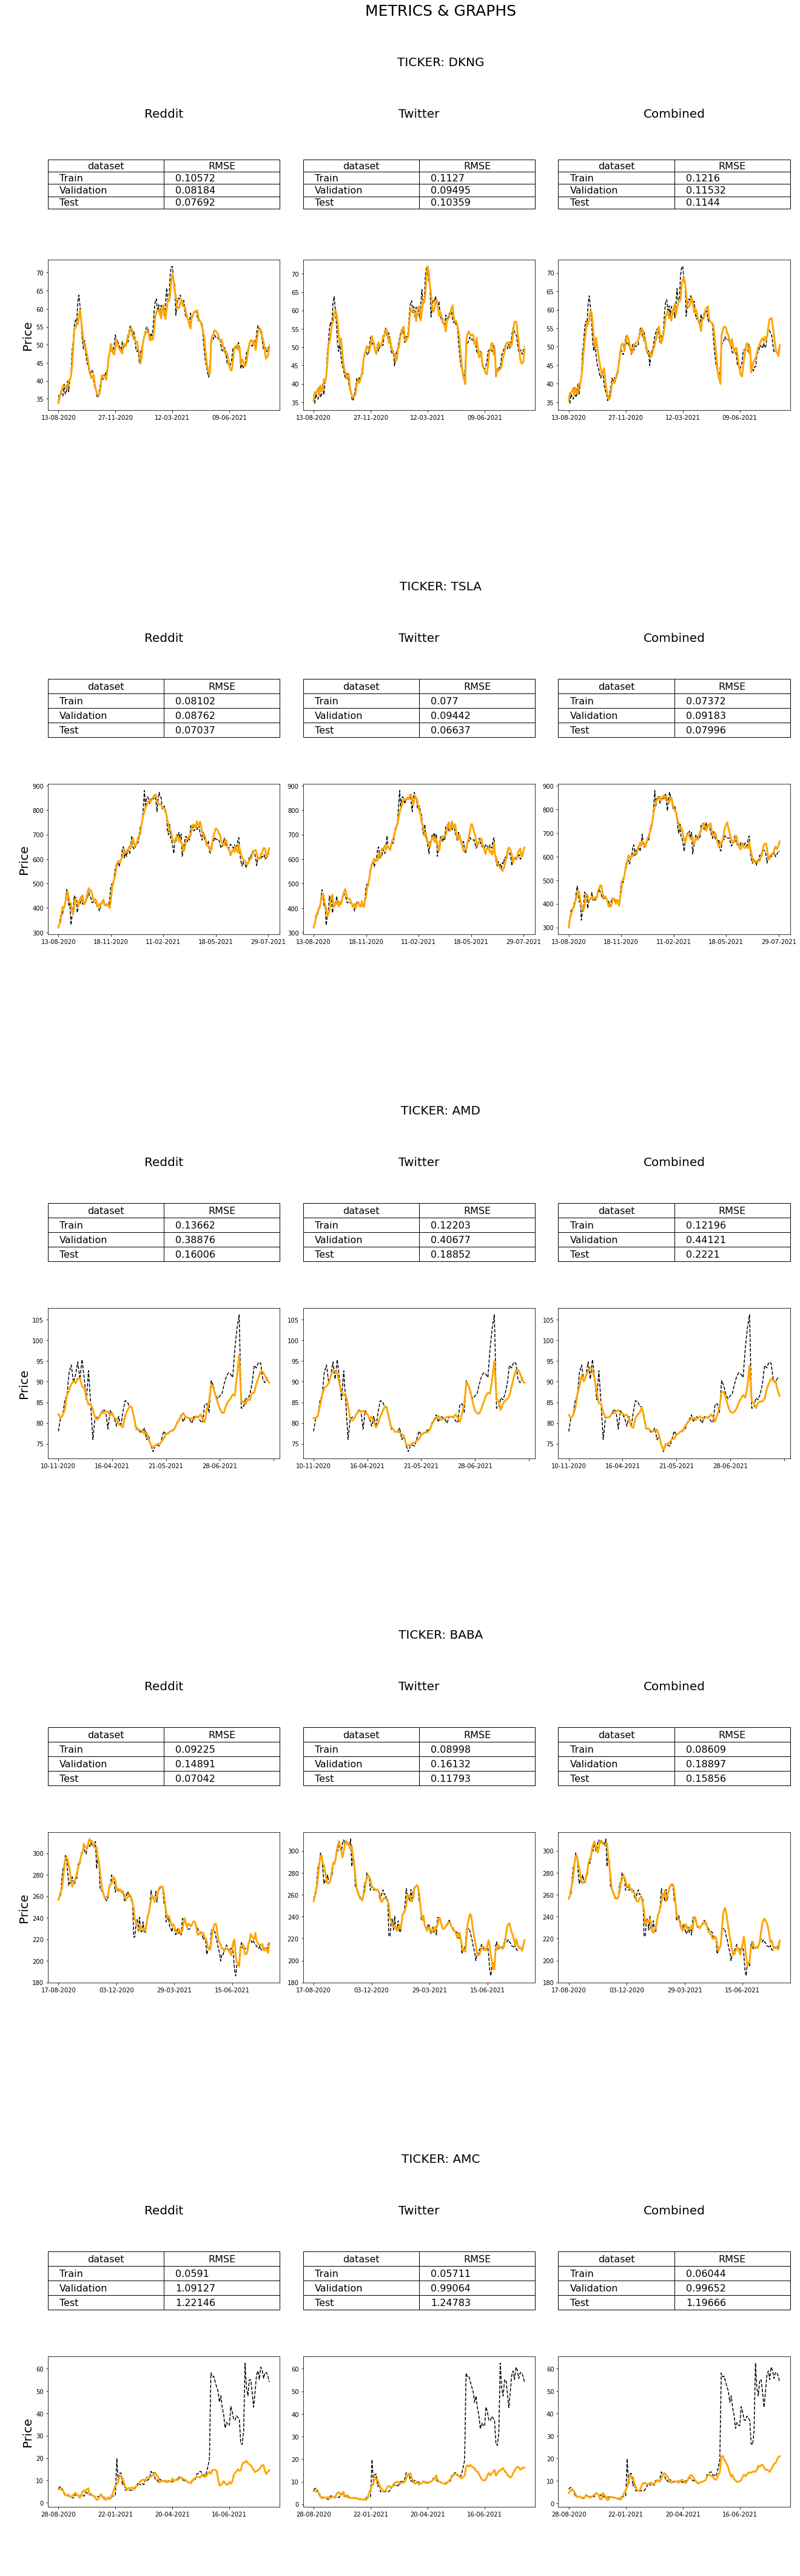

In [7]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# fig = plt.figure(constrained_layout=True, figsize=(30, 60))
fig = plt.figure(figsize=(20, 60))
fig.suptitle('METRICS & GRAPHS', fontsize=25, fontweight=5)
subfigs = fig.subfigures(nrows=len(results_df), ncols=1, hspace = 1)

subfig_no = 0

for tick, tick_val in results_df.items():
    
    ax = subfigs[subfig_no].subplots(nrows=2, ncols=3)
    subplot_row_n = 0
    subfigs[subfig_no].suptitle(f'TICKER: {tick}', fontsize=20, y=0.80)
    
    #--plot the metrics results
    tmp = tick_val['reddit']['metrics'][['dataset','RMSE']].copy(deep=True)
    tmp.iloc[:,1:2]=tmp.iloc[:,1:2].applymap(lambda x: float('%.5f'%(x)))
    table = ax[subplot_row_n,0].table(cellText=tmp.values, colLabels=tick_val['reddit']['metrics'][['dataset','RMSE']].columns, loc='center', cellLoc='left')
    ax[subplot_row_n,0].patch.set_visible(False)
    ax[subplot_row_n,0].axis('off')
    ax[subplot_row_n,0].axis('tight')
    ax[subplot_row_n,0].set_title('Reddit', pad=-14, y=1, fontsize=20)
    table.auto_set_font_size(False)
    table.set_fontsize(16)
    table.scale(1,2)

    
    tmp = tick_val['twitter']['metrics'][['dataset','RMSE']].copy(deep=True)
    tmp.iloc[:,1:2]=tmp.iloc[:,1:2].applymap(lambda x: float('%.5f'%(x)))
    table = ax[subplot_row_n,1].table(cellText=tmp.values, colLabels=tick_val['twitter']['metrics'][['dataset','RMSE']].columns, loc='center', cellLoc='left')
    ax[subplot_row_n,1].patch.set_visible(False)
    ax[subplot_row_n,1].axis('off')
    ax[subplot_row_n,1].axis('tight')
    ax[subplot_row_n,1].set_title('Twitter', pad=-14, y=1, fontsize=20)
    table.auto_set_font_size(False)
    table.set_fontsize(16)
    table.scale(1,2)
    
    tmp = tick_val['combined']['metrics'][['dataset','RMSE']].copy(deep=True)
    tmp.iloc[:,1:2]=tmp.iloc[:,1:2].applymap(lambda x: float('%.5f'%(x)))
    table = ax[subplot_row_n,2].table(cellText=tmp.values, colLabels=tick_val['combined']['metrics'][['dataset','RMSE']].columns, loc='center', cellLoc='left')
    ax[subplot_row_n,2].patch.set_visible(False)
    ax[subplot_row_n,2].axis('off')
    ax[subplot_row_n,2].axis('tight')
    ax[subplot_row_n,2].set_title('Combined', pad=-14, y=1, fontsize=20)
    table.auto_set_font_size(False)
    table.set_fontsize(16)
    table.scale(1,2)


    #--increment row_n
    subplot_row_n += 1

    #--plot the line graphs
    plot_df = tick_val['reddit']['close']
    ax[subplot_row_n, 0].plot(plot_df['Date'], plot_df['true_close'], color='black', linestyle='--');
    ax[subplot_row_n, 0].plot(plot_df['Date'], plot_df['pred_close'], color='orange', linewidth=3);
    ax[subplot_row_n, 0].xaxis.set_major_locator(MaxNLocator(nbins=5))
    
    plot_df = tick_val['twitter']['close']
    ax[subplot_row_n, 1].plot(plot_df['Date'], plot_df['true_close'], color='black', linestyle='--');
    ax[subplot_row_n, 1].plot(plot_df['Date'], plot_df['pred_close'], color='orange', linewidth=3);
    ax[subplot_row_n, 1].xaxis.set_major_locator(MaxNLocator(nbins=5))
    
    plot_df = tick_val['combined']['close']
    ax[subplot_row_n, 2].plot(plot_df['Date'], plot_df['true_close'], color='black', linestyle='--');
    ax[subplot_row_n, 2].plot(plot_df['Date'], plot_df['pred_close'], color='orange', linewidth=3);
    ax[subplot_row_n, 2].xaxis.set_major_locator(MaxNLocator(nbins=5))

    ax[subplot_row_n, 0].tick_params(axis='both', which='major', labelsize=10)
    ax[subplot_row_n, 1].tick_params(axis='both', which='minor', labelsize=10)
    ax[subplot_row_n, 2].tick_params(axis='both', which='minor', labelsize=10)
    ax[subplot_row_n, 0].set_ylabel('Price', fontsize=20)
    
    subfig_no += 1
    
    
    fig.subplots_adjust(left=0.05, bottom=None, right=None, top=0.7, wspace=0.1, hspace=0.0001)

path = r'C:\\Users\\Karthik\\Desktop\\Dissertation\\Plots and metrics\\'
plt.savefig(f'{path}Predictions with sentiments from BERT Model 2.jpg')
plt.show();